# Masques nuages sur les données Landsat C2 L1


## Fichier QA Band

Les données Landsat de Collection 2 Level 1 comportent, à côté des donnnées de 
réflectance pour les différentes bandes, un fichier GeoTiff dont le nom se 
termine par "_QA_PIXEL.TIF". 

Ce fichier de résolution 30 m contient une classification des pixels sur 16 bits.

| Bit | Flag Description | Values |
| - | -- | ------ |
| 0 | Fill | 0 for image data - 1 for fill data |
| 1 | Dilated Cloud | 0 for cloud is not dilated or no cloud - 1 for cloud dilation |
| 2 | Cirrus | 0 for Cirrus Confidence: no confidence level set or Low Confidence - 1 for high confidence cirrus |
| 3 | Cloud | 0 for cloud confidence is not high - 1 for high confidence cloud |
| 4 | Cloud Shadow | 0 for Cloud Shadow Confidence is not high - 1 for high confidence cloud shadow |
| 5 | Snow | 0 for Snow/Ice Confidence is not high - 1 for high confidence snow cover |
| 6 | Clear | 0 if Cloud or Dilated Cloud bits are set - 1 if Cloud and Dilated Cloud bits are not set |
| 7 | Water | 0 for land or cloud - 1 for water |
| 8-9 | Cloud Confidence | 00 for no confidence level set - 01 Low confidence - 10 Medium confidence - 11 High confidence |
| 10-11 | Cloud Shadow Confidence | 00 for no confidence level set - 01 Low confidence - 10 Reserved - 11 High confidence |
| 12-13 | Snow/Ice Confidence | 00 for no confidence level set - 01 Low confidence - 10 Reserved - 11 High confidence |
| 14-15 | Cirrus Confidence | 00 for no confidence level set - 01 Low confidence - 10 Reserved - 11 High confidence |

Remarque : le bit 2 (Cirrus) est utilisé uniquement pour Landsat 8. 
Il est inutilisé pour Landsat 4-5 TM, et pour Landsat 7 ETM.



## Utilisation avec Python et rasterio

### Chargement des données raster

In [1]:
# Chargement des modules
from os import listdir
from os.path import join
import rasterio
import numpy as np
import fiona


### Les fichiers au sein d'un sous-dossier sont nommés à partir du nom de l'image dont il contient les données. Exemple pour l'image LT05_L1TP_225060_20000907_20200906_02_T1 sur Macapa, l'arborescence serait la suivante :  


<img src = "arborescence.png" width="600" height="600">


In [2]:
# liste des données (*.TIF)
# dans data/LC08_L1TP_228056_20130714_20200912_02_T1
d_data = "/home/fouzai/extraction_tache_urbaine/macapa/macapa_2000"
d_img = "LT05_L1TP_225060_20000907_20200906_02_T1"
tif_files = [f for f in listdir(join(d_data, d_img)) if f.endswith(".TIF")]
tif_files


['LT05_L1TP_225060_20000907_20200906_02_T1_B2_superImpose.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_B6.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_MASK_cloud.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_VAA.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_VZA.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_B5.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_QA_RADSAT.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_B1.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_MASK_cloud_superImpose.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_B2.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_B4.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_SAA.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_SZA.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_B7.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_B3.TIF',
 'LT05_L1TP_225060_20000907_20200906_02_T1_QA_PIXEL.TIF']

In [3]:
f_b1 = join(d_data, d_img, d_img + '_B1.TIF')
f_b2 = join(d_data, d_img, d_img + '_B2.TIF')
f_b3 = join(d_data, d_img, d_img + '_B3.TIF')
f_b4 = join(d_data, d_img, d_img + '_B4.TIF')
f_b5 = join(d_data, d_img, d_img + '_B5.TIF')
f_qa_pixel = join(d_data, d_img, d_img + '_QA_PIXEL.TIF')

r_qa_pixel = rasterio.open(f_qa_pixel)
r_qa_pixel.count, r_qa_pixel.width, r_qa_pixel.height, r_qa_pixel.bounds, r_qa_pixel.dtypes, r_qa_pixel.crs

(1,
 7771,
 7011,
 BoundingBox(left=410985.0, bottom=-104715.0, right=644115.0, top=105615.0),
 ('uint16',),
 CRS.from_epsg(32622))

### Quelles sont les valeurs présentes dans la bande QA_Pixels ?

In [4]:
band_qa = r_qa_pixel.read(1)
for value in np.unique(band_qa):
    print(f'{value:0>16b} ({value})')


0000000000000001 (1)
0001010101000000 (5440)
0001010101000010 (5442)
0001010110000000 (5504)
0001010110000010 (5506)
0001011001000000 (5696)
0001011001000010 (5698)
0001011010000000 (5760)
0001011010000010 (5762)
0001011100001000 (5896)
0001110100010000 (7440)
0001110100010010 (7442)
0001111000010000 (7696)
0001111000010010 (7698)


### Application du masque v1: nuages = hiconf (sans le bit 9) + cirrus 

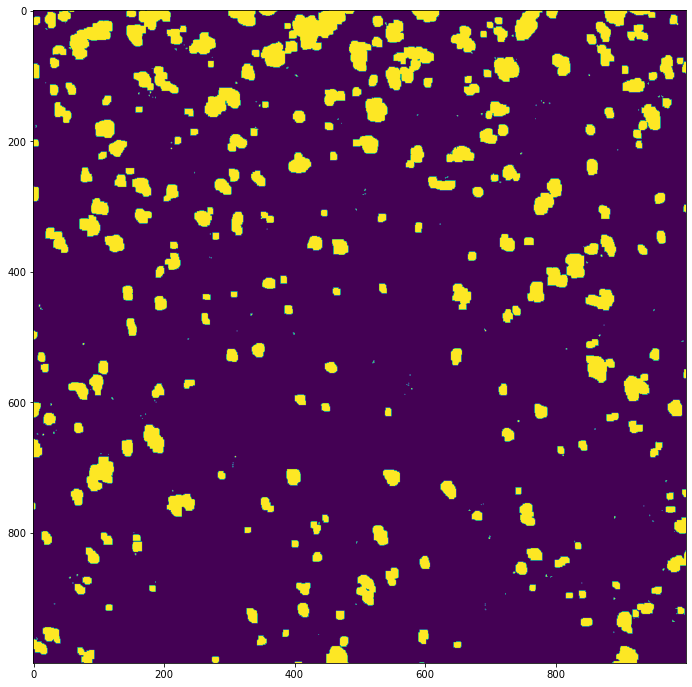

In [6]:
# Dilated cloud + cirrus + cloud
compare_mask_sans = 0b0000000000001110
clouds_v1 = (np.bitwise_and(band_qa, compare_mask_sans) > 0)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clouds_v1[5000:6000, 4500:5500])


In [7]:
# sauvegarde du masque
kwds = r_qa_pixel.profile
kwds['driver'] = 'GTiff'
kwds['dtype'] = 'uint8'
kwds['nodata'] = 255
kwds

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255, 'width': 7771, 'height': 7011, 'count': 1, 'crs': CRS.from_epsg(32622), 'transform': Affine(30.0, 0.0, 410985.0,
       0.0, -30.0, 105615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [ ]:
f_clouds_v1 = join('clouds_v1.tif')
with rasterio.open(f_clouds_v1, 'w', **kwds) as r_output:
    r_output.write(clouds_v1, 1)

### Application du masque v2: nuages >= medconf (avec le bit 9) + cirrus 

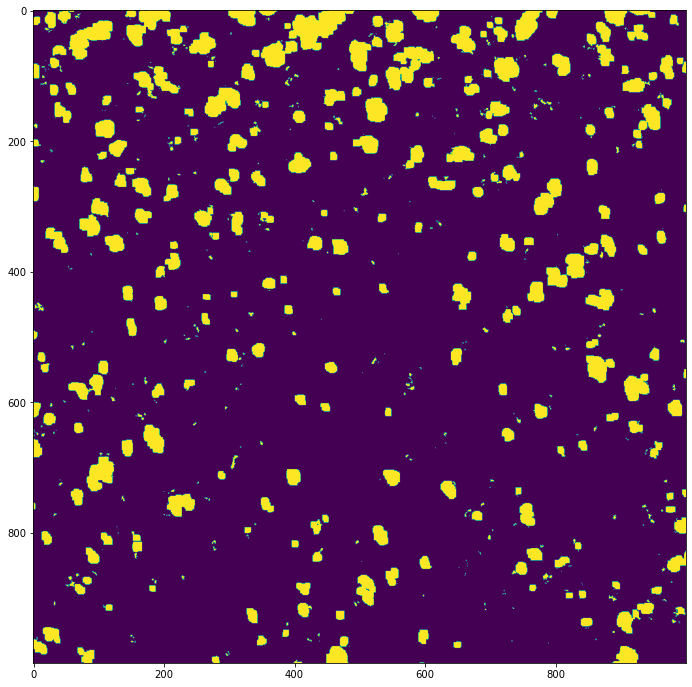

In [10]:
# Dilated cloud + cirrus + cloud (High confidence)
compare_mask_avec = 0b0000001000001110
clouds_v2 = (np.bitwise_and(band_qa, compare_mask_avec) > 0)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clouds_v2[5000:6000, 4500:5500])


In [56]:
f_clouds_v2 = join('output', 'clouds_v2.tif')
with rasterio.open(f_clouds_v2, 'w', **kwds) as r_output:
    r_output.write(clouds_v2, 1)

### Application du masque : ombre des nuages

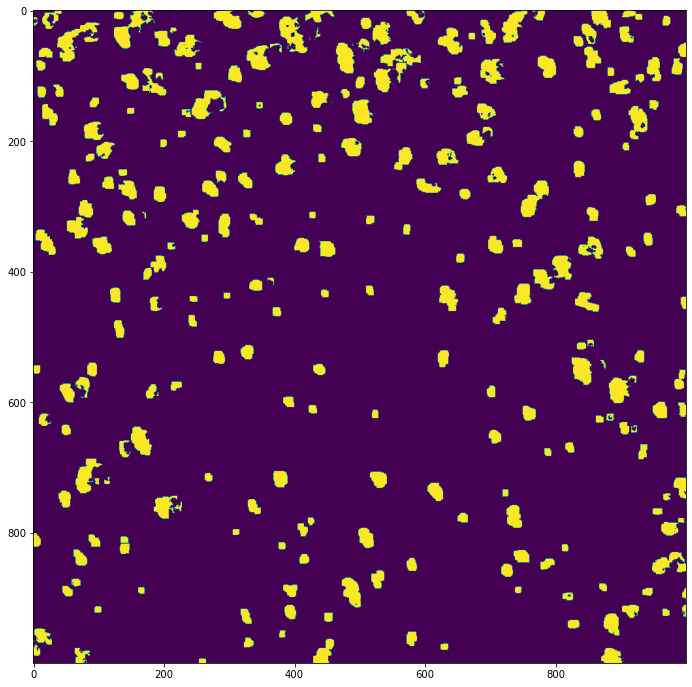

In [11]:
# ombre de nuages
compare_mask_ombre= 0b00000000000010000
shadows = (np.bitwise_and(band_qa, compare_mask_ombre) > 1)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(shadows[5000:6000, 4500:5500])


### Exporter l'ombre de nuage comme raster sous format tif 

In [55]:
f_shadows = join('output', 'shadows.tif')
with rasterio.open(f_shadows, 'w', **kwds) as r_output:
    r_output.write(shadows, 1)

### Afficher le raster

In [12]:
# bandes 1,2,3 et 4
r_b1 = rasterio.open(f_b1)
r_b2 = rasterio.open(f_b2)
r_b3 = rasterio.open(f_b3)
r_b4 = rasterio.open(f_b4)
r_b5 = rasterio.open(f_b5)


In [13]:
# stack bands
band_1 = r_b1.read(1)
band_2 = r_b2.read(1)
band_3 = r_b3.read(1)
band_4 = r_b4.read(1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


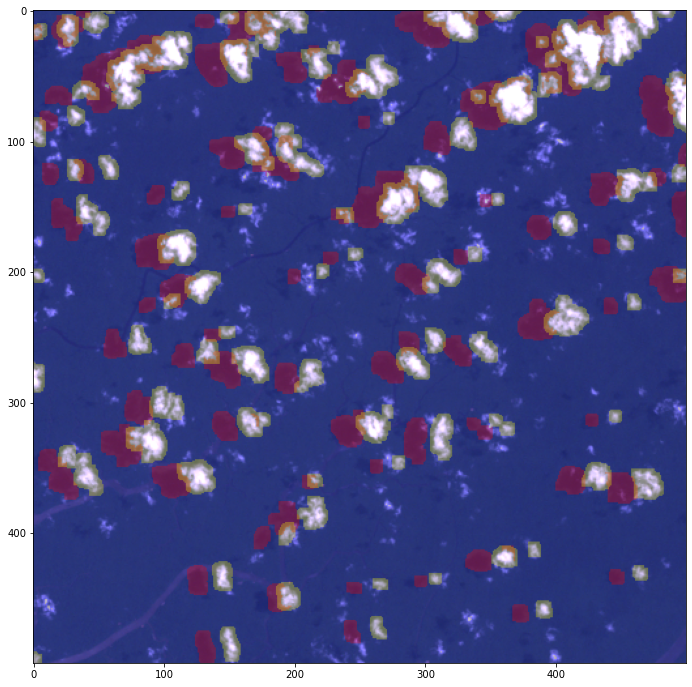

In [24]:
def plot_masked_rgb(red, green, blue, mask, color_mask=(1, 0, 0), transparency=0.5, brightness=2):
    
    # to improve our visualization, we will increase the brightness of our values
    red = red / red.max() * brightness
    green = green / green.max() * brightness
    blue = blue / blue.max() * brightness
    
    red = np.where(mask==True, red*transparency+color_mask[0]*(1-transparency), red)
    green = np.where(mask==True, green*transparency+color_mask[1]*(1-transparency), green)
    blue = np.where(mask==True, blue*transparency+color_mask[2]*(1-transparency), blue)
    
    rgb = np.stack([red, green, blue], axis=2)
    
    return rgb
                

rgb = plot_masked_rgb(band_3, band_2, band_1, shadows, color_mask=(1, 0, 0), transparency=0.7, brightness=2)
rgb = plot_masked_rgb(rgb[..., 0], rgb[..., 1], rgb[..., 2], clouds_v1, color_mask=(1, 1, 0), transparency=0.7, brightness=2)

plt.figure(figsize=(12,12))
plt.imshow(rgb[5000:5500, 4500:5000, 0:3])

<img src="sans_masque.png" width="5000" height="8000" /> <legend align="center" >Image sans masque nuage</legend>
<img src="with_masque.png" width="5000" height="8000" align = "center"   /> <legend align="center" >Image avec masque de nuage</legend>
      


### Ce notebook a été créé par Youssef Fouzai : youssef.fouzai@ird.fr